# Factory Process Regression
		

## Introduction

### Description of physical setup

- The data comes from a continuous flow process. 
- Sample rate is 1 Hz.


- In the first stage, Machines 1, 2, and 3 operate in parallel, and feed their outputs into a step that combines the flows.
- Output from the combiner is measured in 15 locations. These measurements are the **primary measurements to predict.**


- Next, the output flows into a second stage, where Machines 4 and 5 process in series.
- Measurements are made again in the same 15 locations. These are the **secondary measurements to predict**.


- Measurements are noisy.
- Each measurement also has a target or *Setpoint* (setpoints are included in the first row of data).
- The goal is to predict the measurements (or the error versus setpoints) for as many of the 15 measurements as possible.
- Some measurements will be more predictable than others!

### Tasks

- Prediction of measurements after the first stage are the primary interest.
- Prediction of measurements after the second stage are nice-to-have but the data is much more noisy.

### Note on variable naming conventions

- **.C.Setpoint* -- Setpoint for Controlled variable 
- **~.C.Actual* -- Actual value of Controlled variable 
- **~.U.Actual* -- Actual value of Uncontrolled variable 
- *Others* -- Environmental or raw material variables, States / events, etc.

### Columns Desctription

```
Start col |   End col | Description
        0 |         0 | Time stamp
        1 |         2 | Factory ambient conditions
        3 |         6 | First stage, Machine 1, raw material properties (material going in to Machine 1)
        7 |        14 | First stage, Machine 1 process variables
       15 |        18 | First stage, Machine 2, raw material properties (material going in to Machine 2)
       19 |        26 | First stage, Machine 2 process variables
       27 |        30 | First stage, Machine 3, raw material properties (material going in to Machine 3)
       31 |        38 | First stage, Machine 3 process variables
       39 |        41 | Combiner stage process parameters. Here we combines the outputs from Machines 1, 2, and 3.
       42 |        71 | PRIMARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each
       72 |        78 | Second stage, Machine 4 process variables
       79 |        85 | Second stage, Machine 5 process variables
       86 |       115 | SECONDARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each
```

### Acknowledgement

The data was taken from [this project](https://www.kaggle.com/supergus/multistage-continuousflow-manufacturing-process).



## Imports & Drive Mount

In [1]:
%tensorflow_version 2.x
%matplotlib inline

import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
matplotlib.rcParams['figure.figsize'] = (25, 6)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Loading data

In [3]:
!wget https://raw.githubusercontent.com/mlcollege/time-series-analysis/master/data/manufacturing/continuous_factory_process.csv

--2022-10-26 16:06:55--  https://raw.githubusercontent.com/mlcollege/time-series-analysis/master/data/manufacturing/continuous_factory_process.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8509194 (8.1M) [text/plain]
Saving to: ‘continuous_factory_process.csv’

continuous_factory_ 100%[===================>]   8.11M  --.-KB/s    in 0.03s   

2022-10-26 16:06:57 (299 MB/s) - ‘continuous_factory_process.csv’ saved [8509194/8509194]



In [4]:
import pandas as pd

df = pd.read_csv('/content/continuous_factory_process.csv')

Let's check if we can see the structure of the dataset as described...

In [5]:
for i, c in enumerate(df.columns.values):
    print(i, c)

0 time_stamp
1 AmbientConditions.AmbientHumidity.U.Actual
2 AmbientConditions.AmbientTemperature.U.Actual
3 Machine1.RawMaterial.Property1
4 Machine1.RawMaterial.Property2
5 Machine1.RawMaterial.Property3
6 Machine1.RawMaterial.Property4
7 Machine1.RawMaterialFeederParameter.U.Actual
8 Machine1.Zone1Temperature.C.Actual
9 Machine1.Zone2Temperature.C.Actual
10 Machine1.MotorAmperage.U.Actual
11 Machine1.MotorRPM.C.Actual
12 Machine1.MaterialPressure.U.Actual
13 Machine1.MaterialTemperature.U.Actual
14 Machine1.ExitZoneTemperature.C.Actual
15 Machine2.RawMaterial.Property1
16 Machine2.RawMaterial.Property2
17 Machine2.RawMaterial.Property3
18 Machine2.RawMaterial.Property4
19 Machine2.RawMaterialFeederParameter.U.Actual
20 Machine2.Zone1Temperature.C.Actual
21 Machine2.Zone2Temperature.C.Actual
22 Machine2.MotorAmperage.U.Actual
23 Machine2.MotorRPM.C.Actual
24 Machine2.MaterialPressure.U.Actual
25 Machine2.MaterialTemperature.U.Actual
26 Machine2.ExitZoneTemperature.C.Actual
27 Machine3

We'll use `filter` method from pandas to get to the rigth subset of columns:

In [ ]:
df.filter(regex='^Stage1.Output.Measurement.*Actual$').columns

Index(['Stage1.Output.Measurement0.U.Actual',
       'Stage1.Output.Measurement1.U.Actual',
       'Stage1.Output.Measurement2.U.Actual',
       'Stage1.Output.Measurement3.U.Actual',
       'Stage1.Output.Measurement4.U.Actual',
       'Stage1.Output.Measurement5.U.Actual',
       'Stage1.Output.Measurement6.U.Actual',
       'Stage1.Output.Measurement7.U.Actual',
       'Stage1.Output.Measurement8.U.Actual',
       'Stage1.Output.Measurement9.U.Actual',
       'Stage1.Output.Measurement10.U.Actual',
       'Stage1.Output.Measurement11.U.Actual',
       'Stage1.Output.Measurement12.U.Actual',
       'Stage1.Output.Measurement13.U.Actual',
       'Stage1.Output.Measurement14.U.Actual'],
      dtype='object')

## Data preparation - *Stage 1*

Let's start with the standard normalization for each manufacturing step separately:

In [ ]:
def rescale(data):
    mean_vals = data.mean()
    std_vals = data.std()
    return (data - mean_vals) / std_vals

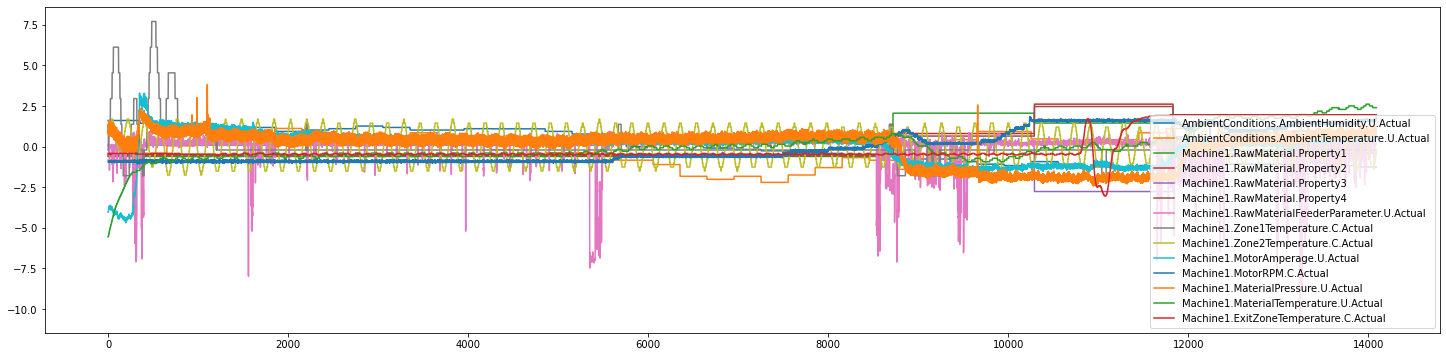

In [ ]:
machine1_train_X = rescale(df.filter(regex='(^Machine1)|(^AmbientConditions)'))
machine1_train_X.plot()
plt.show()

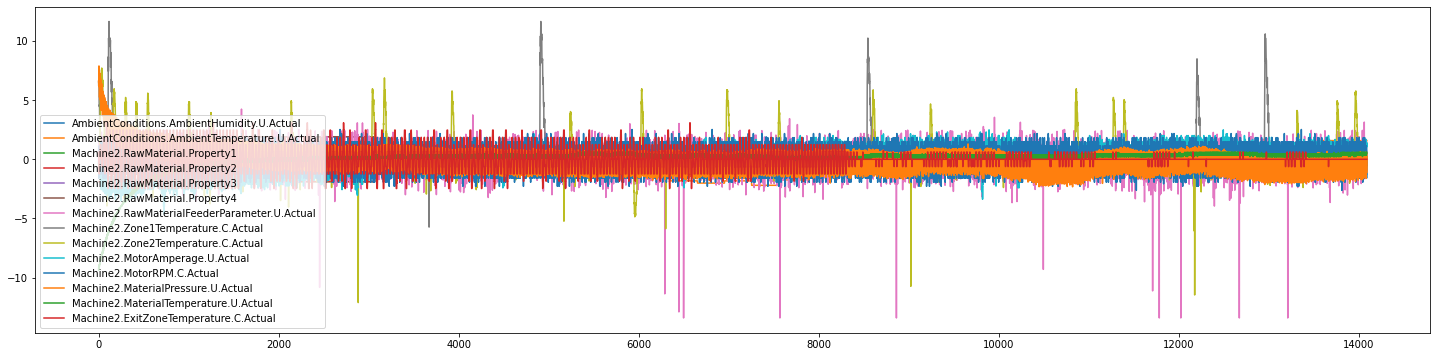

In [ ]:
machine2_train_X = rescale(df.filter(regex='(^Machine2)|(^AmbientConditions)'))
machine2_train_X.plot()
plt.show()

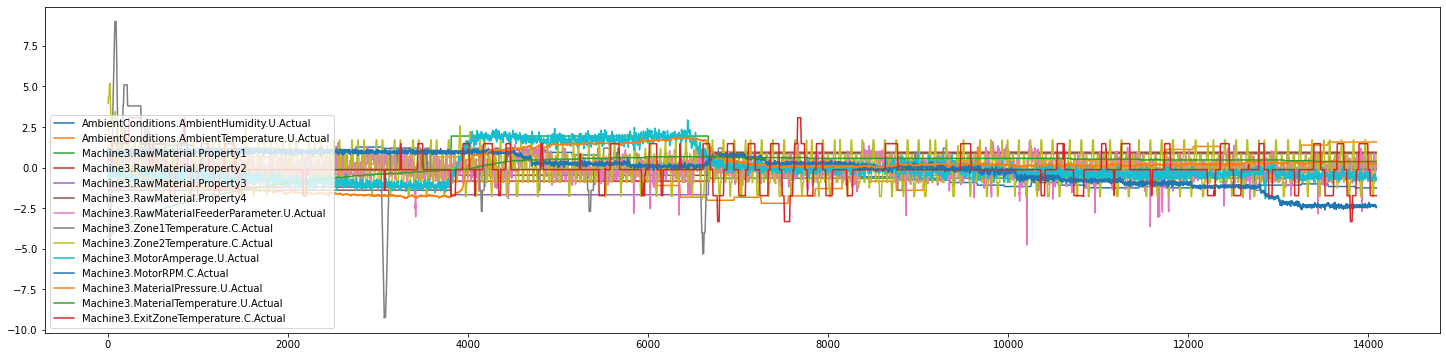

In [ ]:
machine3_train_X = rescale(df.filter(regex='(^Machine3)|(^AmbientConditions)'))
machine3_train_X.rolling(3).mean().plot()
plt.show()

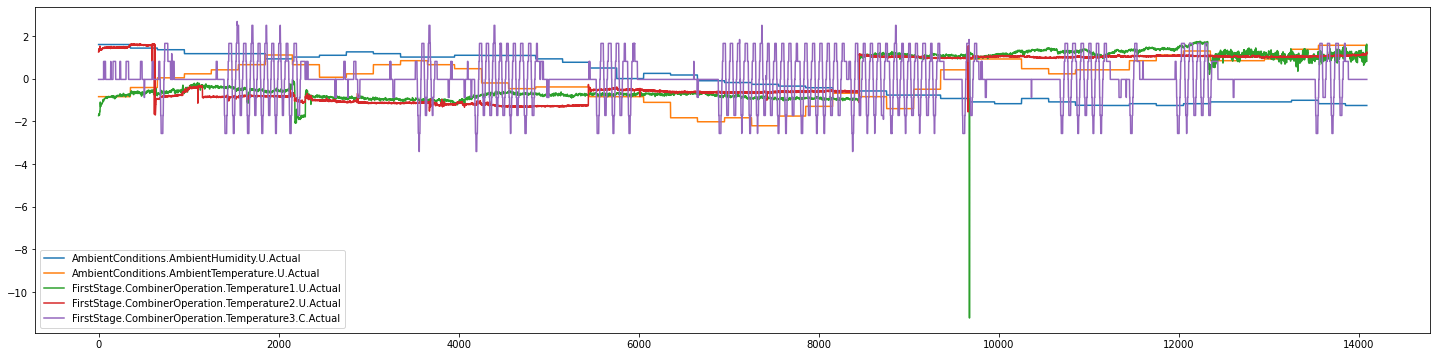

In [ ]:
combiner_train_X = rescale(df.filter(regex='(^FirstStage.CombinerOperation)|(^AmbientConditions)'))
combiner_train_X.plot()
plt.show()

^ There's some noise in the input data and we might consider to apply some smoothing (perhaps rolling mean with a small window) to some of the quantities. Or, let the neural network deal with the noise.

Now let's see setpoints and measured values:

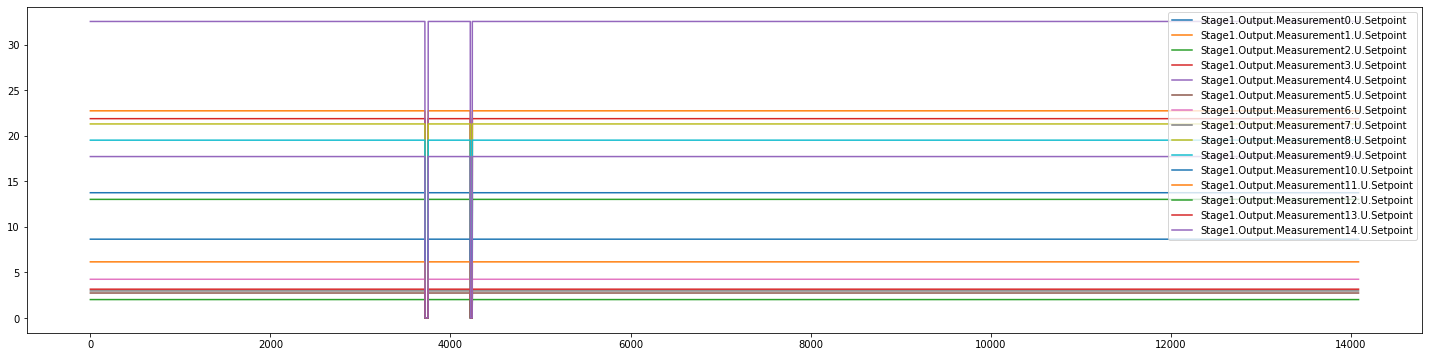

In [ ]:
stage_1_setpoints = df.filter(regex='^Stage1.*Setpoint$').plot()
plt.show()

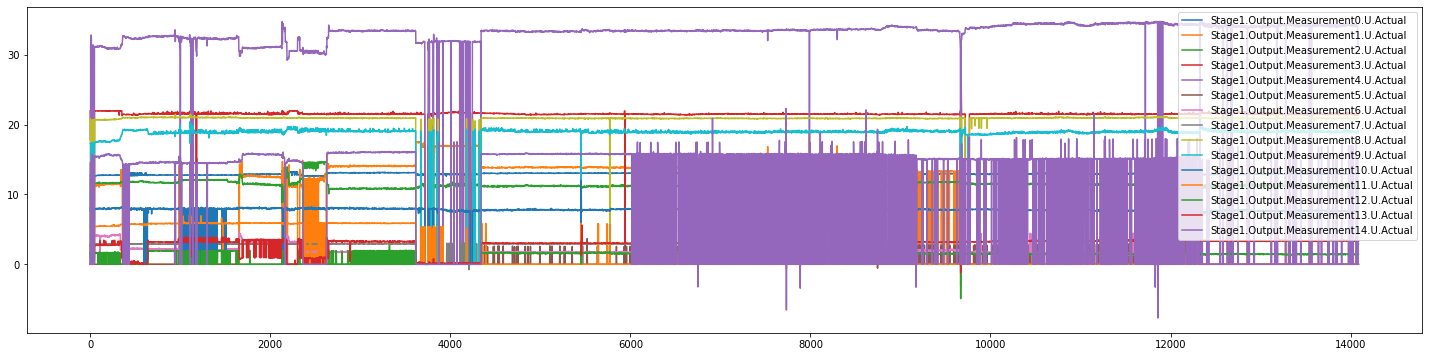

In [ ]:
df.filter(regex='^Stage1.*Actual$').plot()
plt.show()

^ That looks like there are **many missing values** as these measurements should be positive but many times we can see zeros or oscillation between a value and 0. 

Ok, let's just replace all missing values with `NA` and consider them as missing targets.
Also, let's subtract setpoints from actual values and let's try to **predict errors in manufacturing process.**

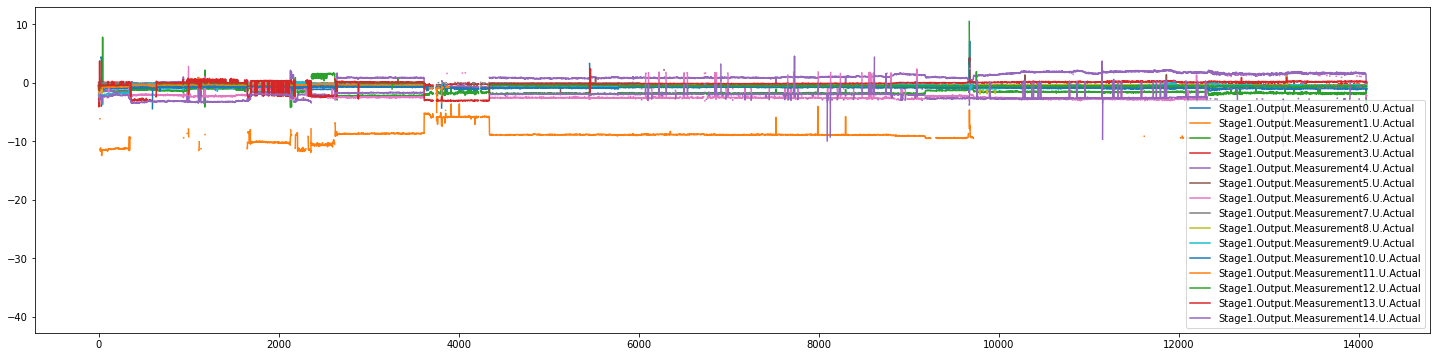

In [ ]:
stage_1_setpoints = df.filter(regex='^Stage1.*Setpoint$').replace(0, pd.NA).values
stage1_train_Y = df.filter(regex='^Stage1.*Actual$').replace(0, pd.NA) - stage_1_setpoints
stage1_train_Y.plot()
plt.show()

## Model construction - *Stage 1*

First, let's **deal with the missing target values**. If we would leave `NA` values in the dataset, they would back-propagate to the network and crush the training. Although there are `Masking` layers for missing data at the input, for the outputs/targets we have to find a different way.

The idea is to **ignore samples** if there's a `NA` at the target variable. "Ignoring" in terms of back-propagation means that such samples will **generate zero loss** i.e. will not move weights in any direction.

Thi implement this behavior, we need a **custom MSE loss function.**:

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import mse

# The loss function operates on the whole batch so all operations must be vectorized
def masked_loss_function(y_true, y_pred):

    # make these constants explicit to speedup the process
    zero = tf.constant(0.0)
    one = tf.constant(1.0)

    # boolean flag for missing values
    missing_vals = tf.math.is_nan(y_true)        

    # store how many valid values we have in each sample in batch 
    num_valid = tf.reduce_sum(
        tf.cast(tf.logical_not(missing_vals), y_true.dtype),
        axis=-1
    )
    # prepare division for each sample to compute a correct mean in MSE
    divider = tf.maximum(num_valid, one)    

    # return MSE based on valid values (by zeroing missing values)
    return (
        tf.reduce_sum(
            tf.square(
                tf.where(missing_vals, 0.0, y_true) - tf.where(missing_vals, 0.0, y_pred)
            ),
            axis=-1
        ) / divider
    )

If we test the loss function with NaNs, it works correctly:

In [ ]:
masked_loss_function(
    tf.constant([[0.0, 1.0], [np.nan, 1.0], [np.nan, np.nan]]), 
    tf.constant([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]])
)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.25, 0.25, 0.  ], dtype=float32)>

For the model construction, we could go woth the standard `inputs --> outputs` model definition but this time, the process itself forms a DAG where diferent inputs comes into play at different stages.

To prevent the model to pick wrong input features and narrow down possible paths to a solution, we can create a hierarchical model based on the manufactuting process description:

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Input, Dense, Concatenate

m1_inputs = Input(shape=(None, machine1_train_X.shape[-1]))
m1_1 = Dense(16)(m1_inputs)
m1_outputs = LSTM(16, return_sequences=True)(m1_1)

m2_inputs = Input(shape=(None, machine2_train_X.shape[-1]))
m2_1 = Dense(16)(m2_inputs)
m2_outputs = LSTM(16, return_sequences=True)(m2_1)

m3_inputs = Input(shape=(None, machine3_train_X.shape[-1]))
m3_1 = Dense(16)(m3_inputs)
m3_outputs = LSTM(16, return_sequences=True)(m3_1)

combiner_inputs = Input(shape=(None, combiner_train_X.shape[-1]))
combiner_1 = Concatenate()([combiner_inputs, m1_outputs, m2_outputs, m3_outputs])
combiner_output = LSTM(16, return_sequences=True)(combiner_1)

prediction_point1 = Dense(stage1_train_Y.shape[-1])(combiner_output)

stage1_model = Model([m1_inputs, m2_inputs, m3_inputs, combiner_inputs], prediction_point1)
stage1_model.compile(optimizer='rmsprop', loss=masked_loss_function)
stage1_model.summary()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
dense_100 (Dense)               (None, None, 16)     240         input_47[0][0]                   
______________________________________________________________________________________

As you can see from the summary, we built a DAG like this:
```
M1_I  M2_I  M3_I
 V    V     V
|M1| |M2| |M3|
  \\  ||  //
   \\ || //
CI-->[CB]
      ||
     [P1]-->
```
There are 4 input tensors and 1 output connected to stage 1 target variable.

In [ ]:
SEQ_LEN = 100
STRIDE = SEQ_LEN // 2
PREDICTION_OFFSET = 0
VALIDATION_SPLIT = 0.2

sample_indices = np.array(range((len(df) - PREDICTION_OFFSET) // STRIDE)) * STRIDE

VALIDATION_MARK = int(len(sample_indices) * (1.0 - VALIDATION_SPLIT))
VALIDATION_MARK

224

In [ ]:
all_train_X = [
    np.array([dataset.values[i:i+SEQ_LEN] for i in sample_indices[:VALIDATION_MARK]])
    for dataset in (machine1_train_X, machine2_train_X, machine3_train_X, combiner_train_X)
]
all_train_Y = np.array([stage1_train_Y.values[i+PREDICTION_OFFSET:i+SEQ_LEN+PREDICTION_OFFSET] for i in sample_indices[:VALIDATION_MARK]])

for x in all_train_X:
    print(x.shape)
print("-----")
print(all_train_Y.shape)

(224, 100, 14)
(224, 100, 14)
(224, 100, 14)
(224, 100, 5)
-----
(224, 100, 15)


In [ ]:
shuffle_indices = list(range(len(all_train_Y)))
random.shuffle(shuffle_indices)

all_train_X = [
    dataset[shuffle_indices] for dataset in all_train_X
]
all_train_Y = all_train_Y[shuffle_indices]

In [ ]:
stage1_model.fit(all_train_X, all_train_Y, epochs=400)

## Model evaluation - *Stage 1*

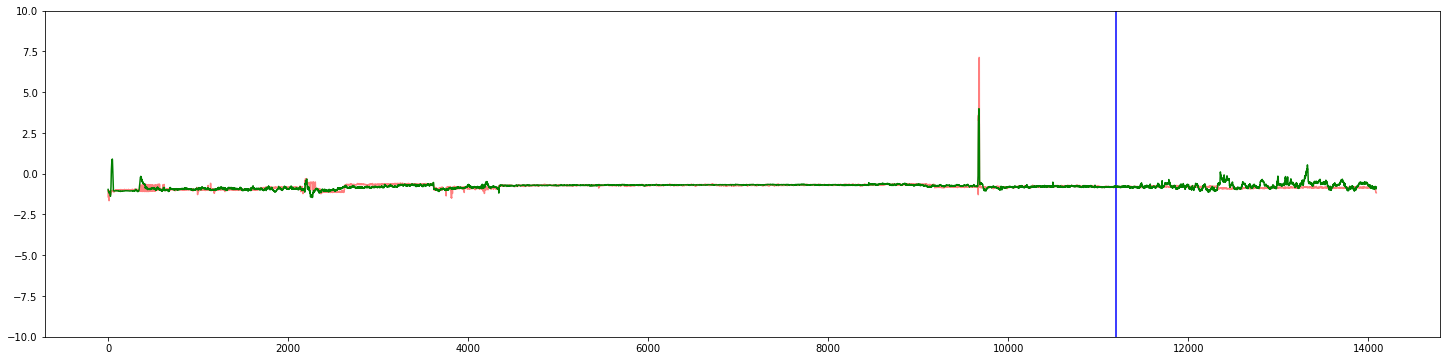

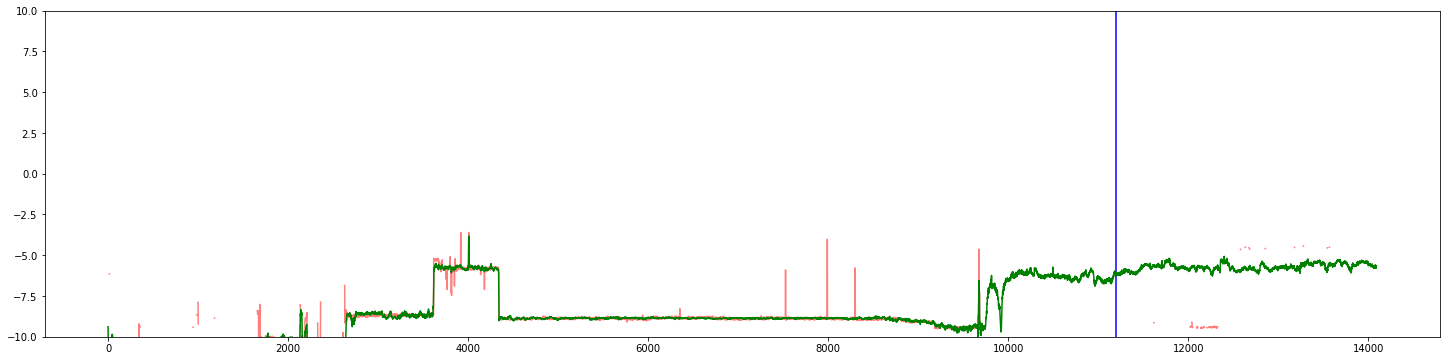

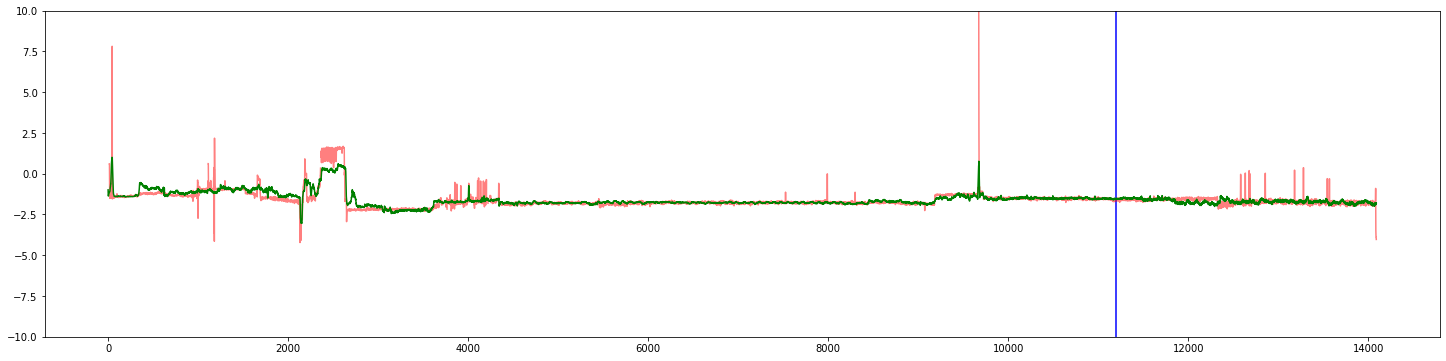

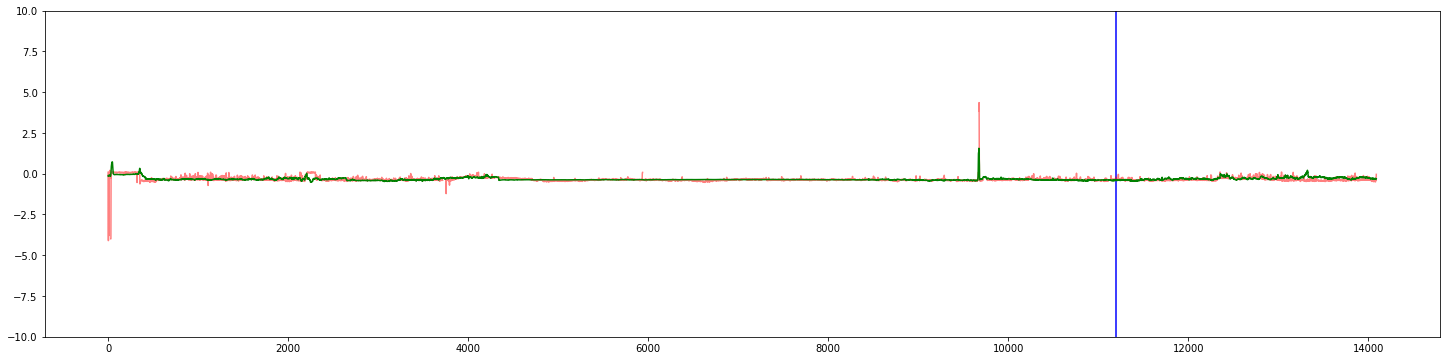

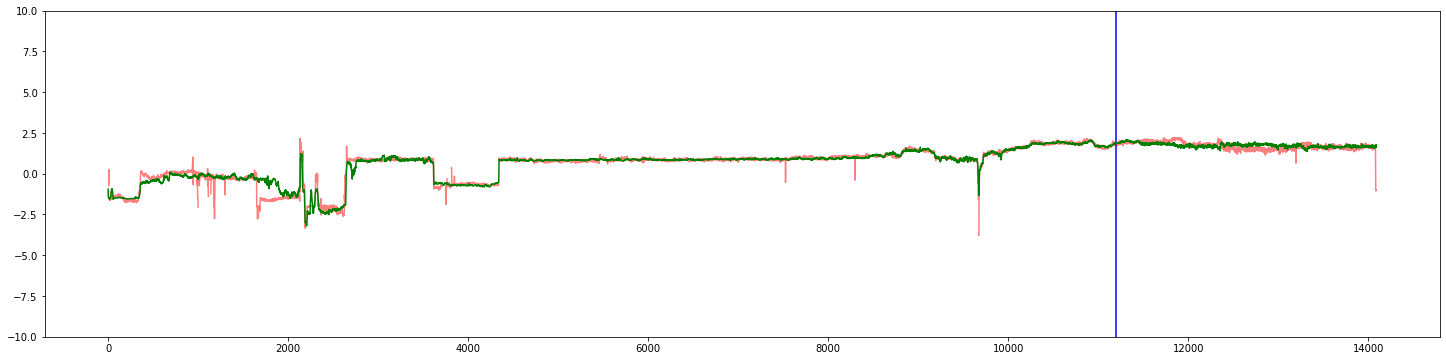

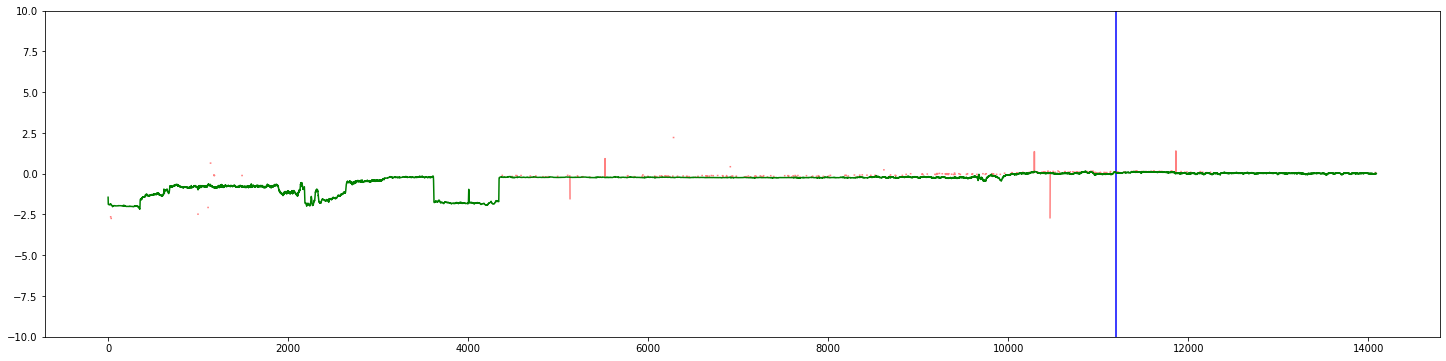

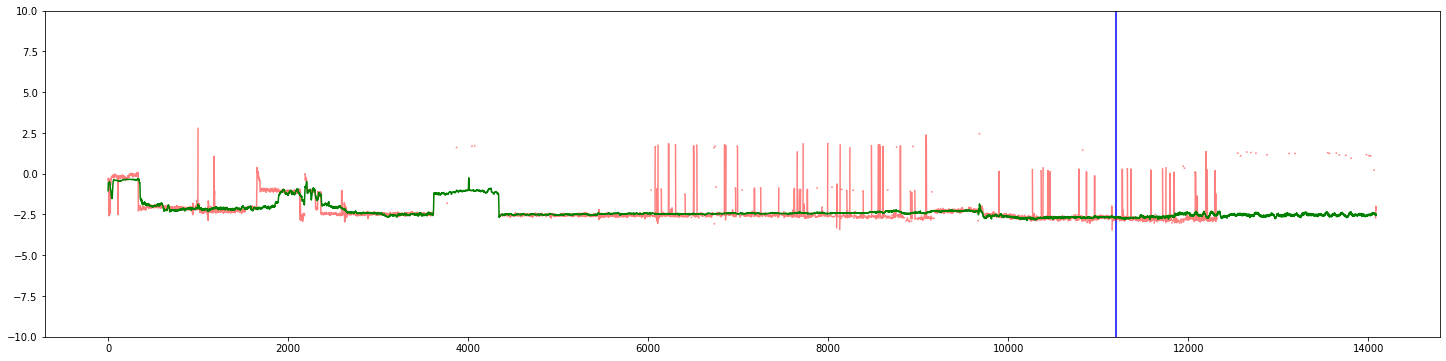

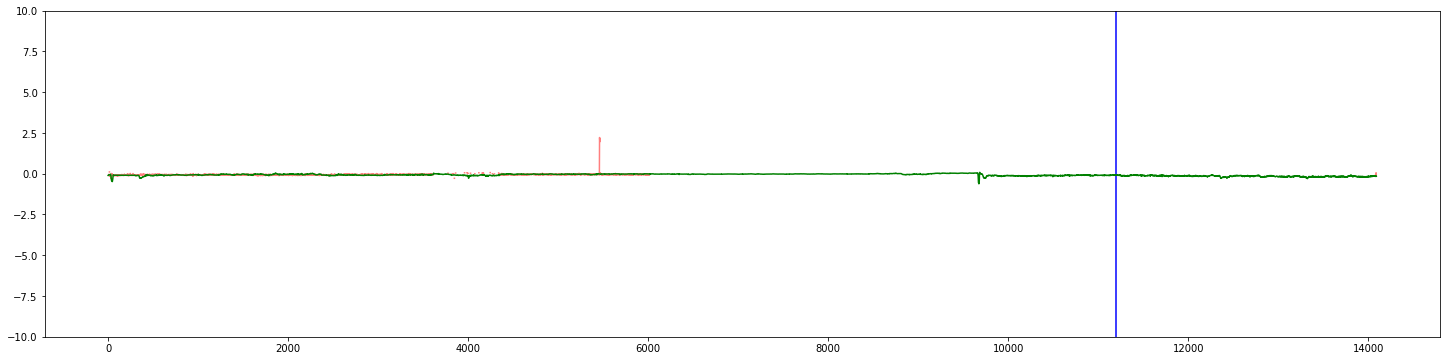

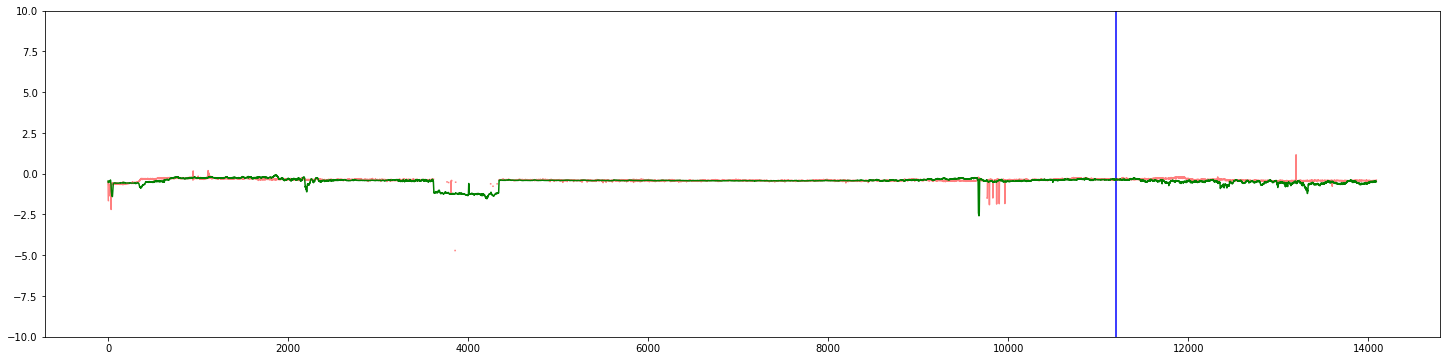

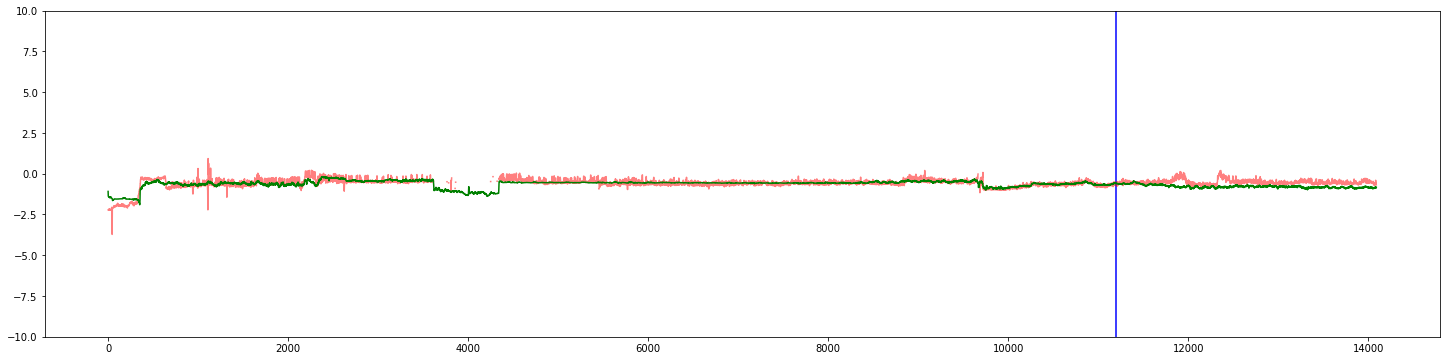

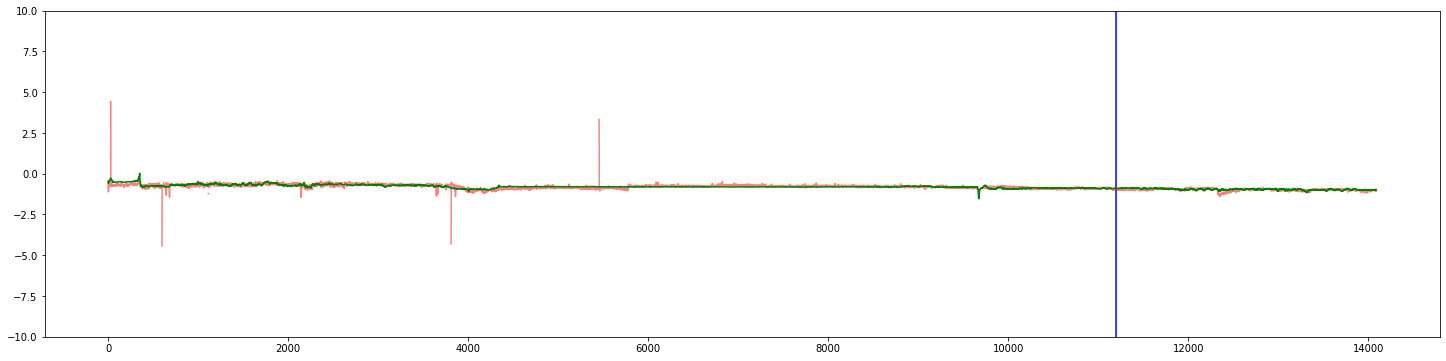

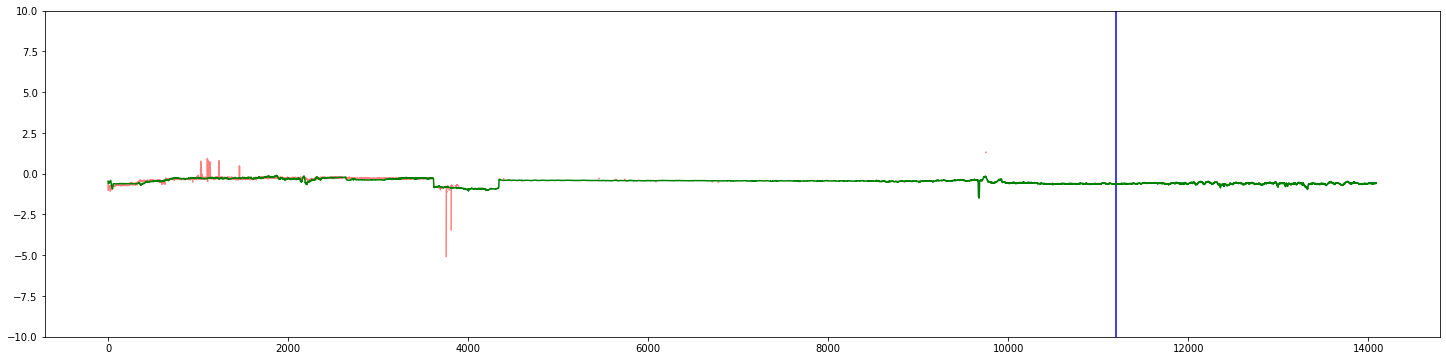

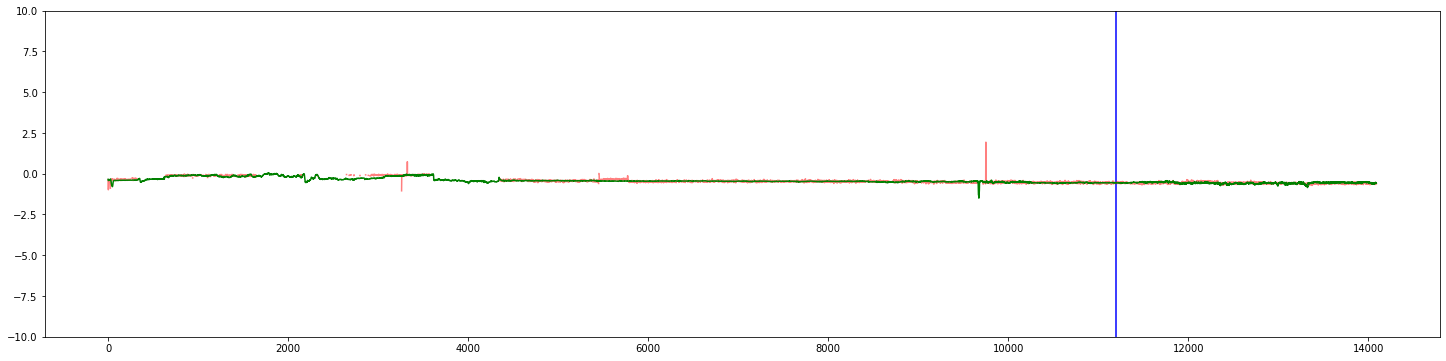

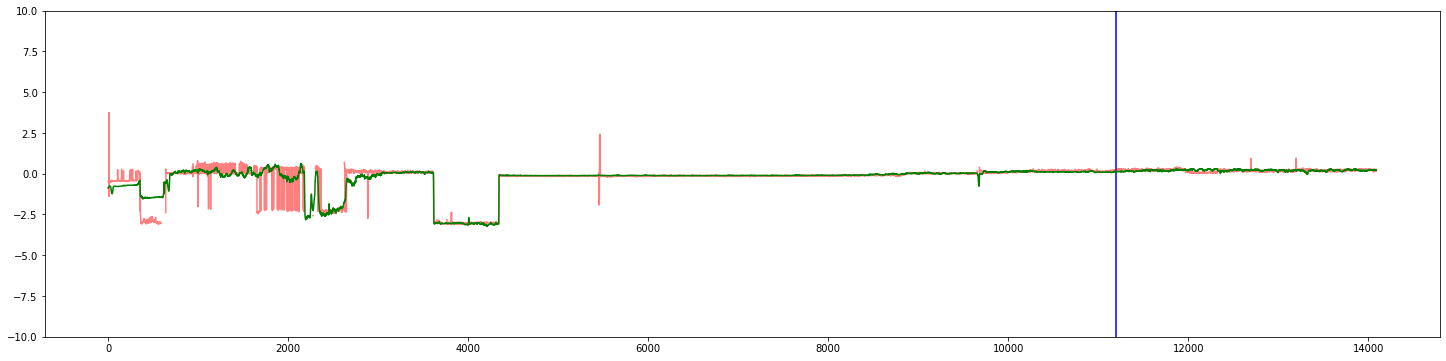

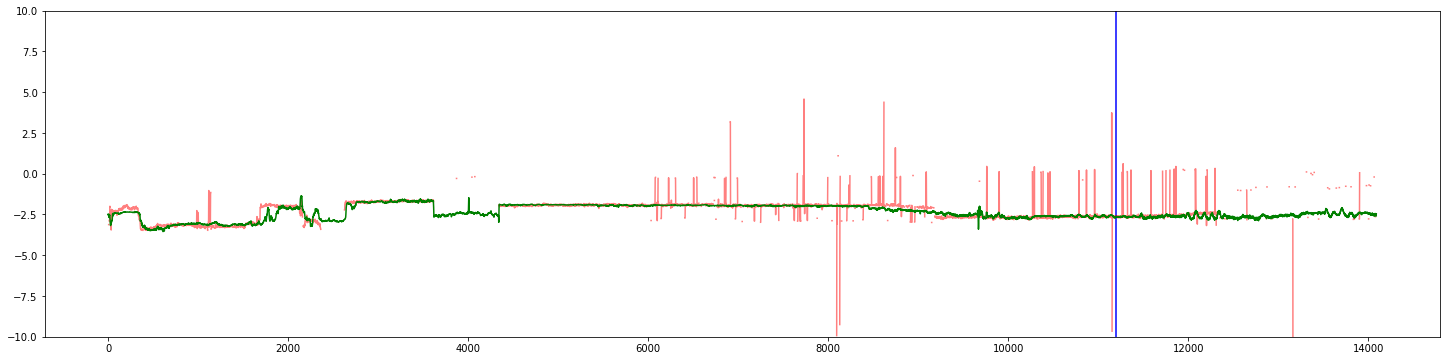

In [ ]:
pred_inputs = [
    np.expand_dims(t, 0) for t in
    (machine1_train_X, machine2_train_X, machine3_train_X, combiner_train_X)
]
prediction = stage1_model.predict(pred_inputs)[0]

for i in range(prediction.shape[-1]):
    plt.plot(stage1_train_Y.iloc[PREDICTION_OFFSET:,i].values, 'r', alpha=0.5)    
    plt.plot(prediction[:len(prediction)-PREDICTION_OFFSET,i], "g-")
    plt.vlines([VALIDATION_MARK * STRIDE], -10, 10, colors='b')
    plt.ylim(-10, 10)
    plt.show()   

## Data preparation - *Stage 2*

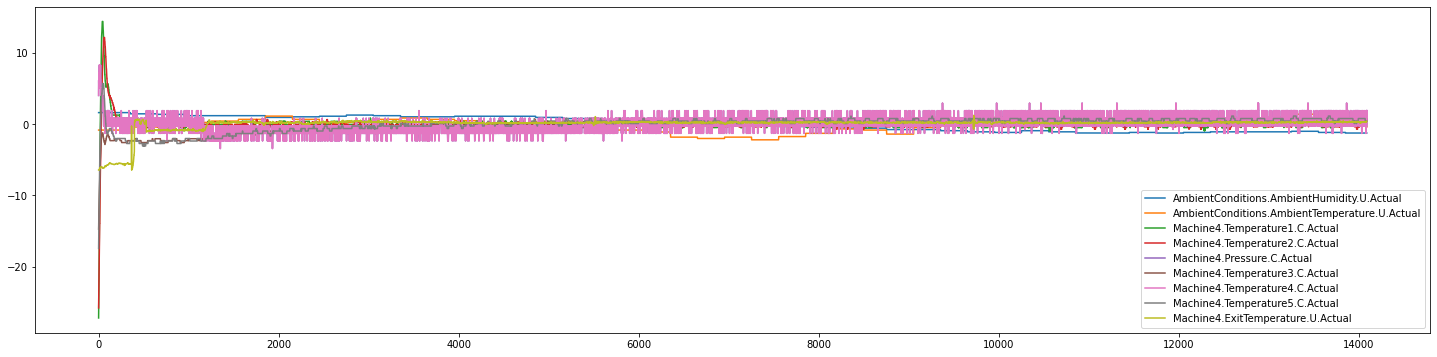

In [ ]:
machine4_train_X = rescale(df.filter(regex='(^Machine4)|(^AmbientConditions)'))
machine4_train_X.plot()
plt.show()

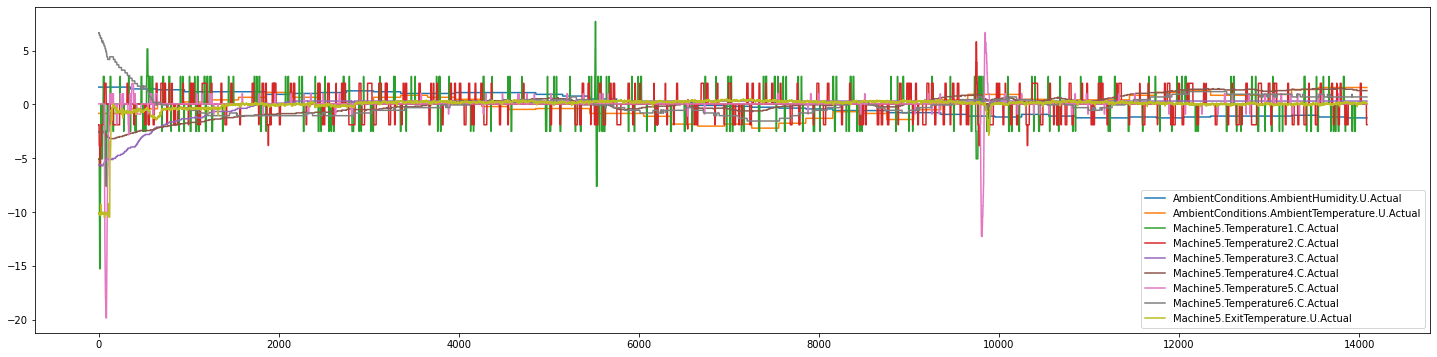

In [ ]:
machine5_train_X = rescale(df.filter(regex='(^Machine5)|(^AmbientConditions)'))
machine5_train_X.plot()
plt.show()

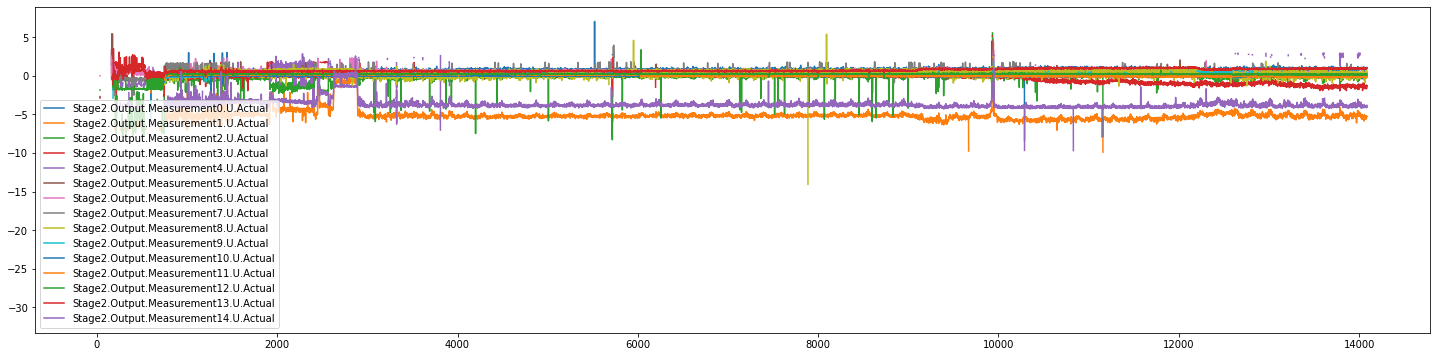

In [ ]:
stage_2_setpoints = df.filter(regex='^Stage2.*Setpoint$').replace(0, pd.NA).values
stage2_train_Y = df.filter(regex='^Stage2.*Actual$').replace(0, pd.NA) - stage_2_setpoints
stage2_train_Y.plot()
plt.show()

## Model construction - *Stage 2*

In [ ]:
m1_inputs = Input(shape=(None, machine1_train_X.shape[-1]), name='m1_inputs')
m1_1 = Dense(16, activation='relu')(m1_inputs)
m1_outputs = LSTM(16, return_sequences=True, name='m1_outputs')(m1_1)

m2_inputs = Input(shape=(None, machine2_train_X.shape[-1]), name='m2_inputs')
m2_1 = Dense(16, activation='relu')(m2_inputs)
m2_outputs = LSTM(16, return_sequences=True, name='m2_outputs')(m2_1)

m3_inputs = Input(shape=(None, machine3_train_X.shape[-1]), name='m3_inputs')
m3_1 = Dense(16, activation='relu')(m3_inputs)
m3_outputs = LSTM(16, return_sequences=True, name='m3_outputs')(m3_1)

combiner_inputs = Input(shape=(None, combiner_train_X.shape[-1]), name='combiner_inputs')
combiner_1 = Concatenate()([combiner_inputs, m1_outputs, m2_outputs, m3_outputs])
combiner_2 = Dense(32, activation='relu')(combiner_1)
combiner_output = LSTM(16, return_sequences=True, name='combiner_outputs')(combiner_2)

prediction_point1 = Dense(stage1_train_Y.shape[-1], name='P1')(combiner_output)

m4_inputs = Input(shape=(None, machine4_train_X.shape[-1]), name='m4_inputs')
m4_1 = Concatenate()([m4_inputs, prediction_point1])
m4_2 = Dense(32, activation='relu')(m4_1)
m4_outputs = LSTM(32, return_sequences=True, name='m4_outputs')(m4_2)

m5_inputs = Input(shape=(None, machine5_train_X.shape[-1]), name='m5_inputs')
m5_1 = Concatenate()([m5_inputs, m4_outputs])
m5_2 = Dense(32, activation='relu')(m5_1)
m5_outputs = LSTM(32, return_sequences=True, name='m5_outputs')(m5_2)

prediction_point2 = Dense(stage2_train_Y.shape[-1], name='P2')(m5_outputs)

stage2_model = Model([m1_inputs, m2_inputs, m3_inputs, combiner_inputs, m4_inputs, m5_inputs], [prediction_point1, prediction_point2])
stage2_model.compile(optimizer='rmsprop', loss=[masked_loss_function, masked_loss_function], loss_weights=[1.0, 1.0])
#stage2_model.summary()

In [ ]:
SEQ_LEN = 200
STRIDE = SEQ_LEN // 4
PREDICTION_OFFSET = 0
VALIDATION_SPLIT = 0.2

sample_indices = np.array(range((len(df) - PREDICTION_OFFSET) // STRIDE)) * STRIDE

VALIDATION_MARK = int(len(sample_indices) * (1.0 - VALIDATION_SPLIT))
VALIDATION_MARK

224

In [ ]:
all_train_X = [
    np.array([dataset.values[i:i+SEQ_LEN] for i in sample_indices[:VALIDATION_MARK]])
    for dataset in (machine1_train_X, machine2_train_X, machine3_train_X, combiner_train_X, machine4_train_X, machine5_train_X)
]
all_train_Y = [
    np.array([stage1_train_Y.values[i+PREDICTION_OFFSET:i+SEQ_LEN+PREDICTION_OFFSET] for i in sample_indices[:VALIDATION_MARK]]),
    np.array([stage2_train_Y.values[i+PREDICTION_OFFSET:i+SEQ_LEN+PREDICTION_OFFSET] for i in sample_indices[:VALIDATION_MARK]])
]

for x in all_train_X:
    print(x.shape)
print("-----")
for y in all_train_Y:
    print(y.shape)    

(224, 200, 14)
(224, 200, 14)
(224, 200, 14)
(224, 200, 5)
(224, 200, 9)
(224, 200, 9)
-----
(224, 200, 15)
(224, 200, 15)


In [ ]:
shuffle_indices = list(range(len(all_train_Y[0])))
random.shuffle(shuffle_indices)

all_train_X = [
    dataset[shuffle_indices] for dataset in all_train_X
]

all_train_Y = [
    dataset[shuffle_indices] for dataset in all_train_Y
]

In [ ]:
stage2_model.fit(all_train_X, all_train_Y, epochs=400)

Epoch 1/400
7/7 [==============================] - 0s 44ms/step - loss: 8.6707 - P1_loss: 5.9369 - P2_loss: 2.7338
Epoch 2/400
7/7 [==============================] - 0s 38ms/step - loss: 6.5240 - P1_loss: 5.1250 - P2_loss: 1.3990
Epoch 3/400
7/7 [==============================] - 0s 37ms/step - loss: 5.3870 - P1_loss: 4.5510 - P2_loss: 0.8360
Epoch 4/400
7/7 [==============================] - 0s 38ms/step - loss: 4.6478 - P1_loss: 4.0629 - P2_loss: 0.5849
Epoch 5/400
7/7 [==============================] - 0s 36ms/step - loss: 4.1024 - P1_loss: 3.6397 - P2_loss: 0.4628
Epoch 6/400
7/7 [==============================] - 0s 37ms/step - loss: 3.6606 - P1_loss: 3.2532 - P2_loss: 0.4074
Epoch 7/400
7/7 [==============================] - 0s 36ms/step - loss: 3.2774 - P1_loss: 2.8938 - P2_loss: 0.3836
Epoch 8/400
7/7 [==============================] - 0s 36ms/step - loss: 2.9684 - P1_loss: 2.5985 - P2_loss: 0.3699
Epoch 9/400
7/7 [==============================] - 0s 36ms/step - loss: 2.7408 -

## Model evaluation - *Stage 2*

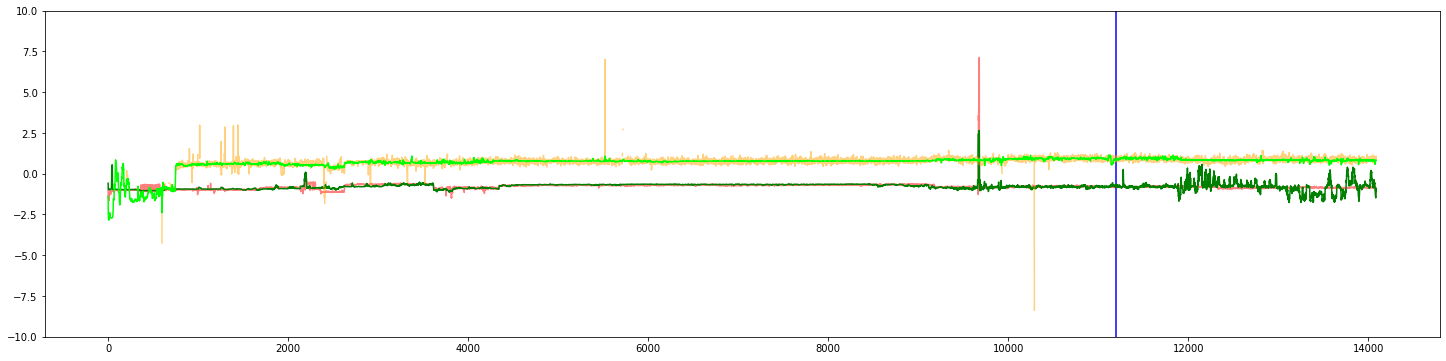

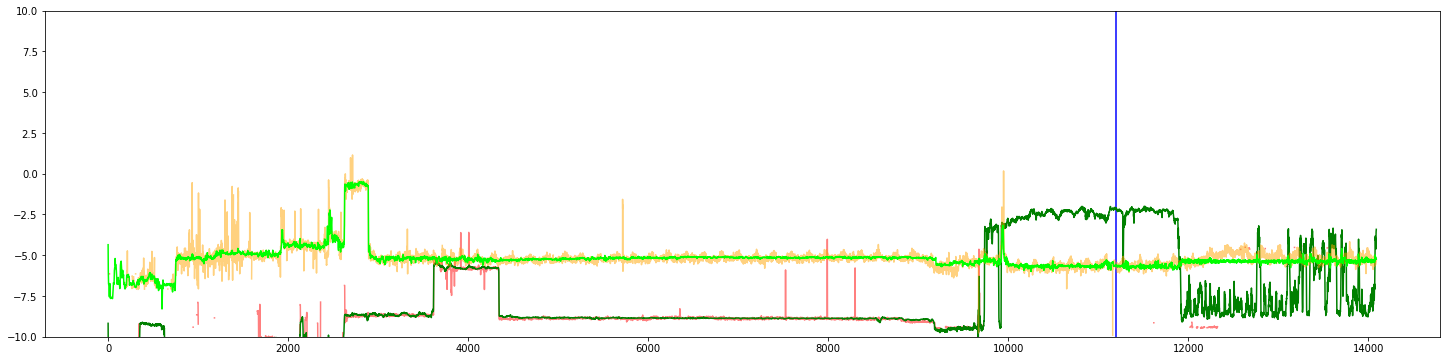

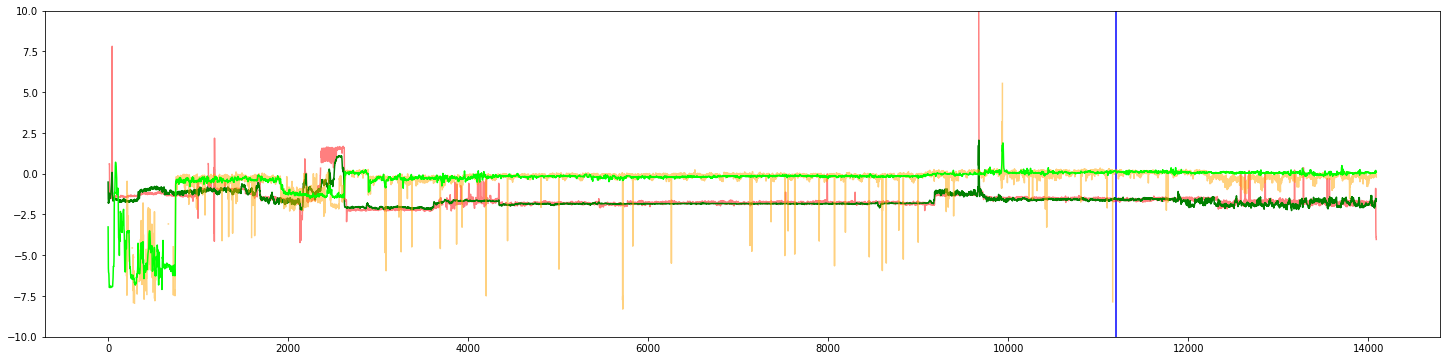

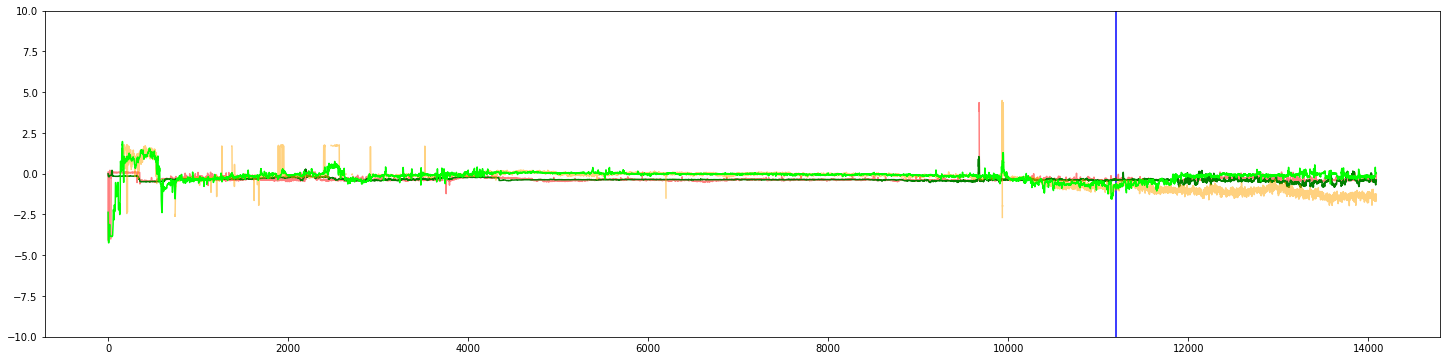

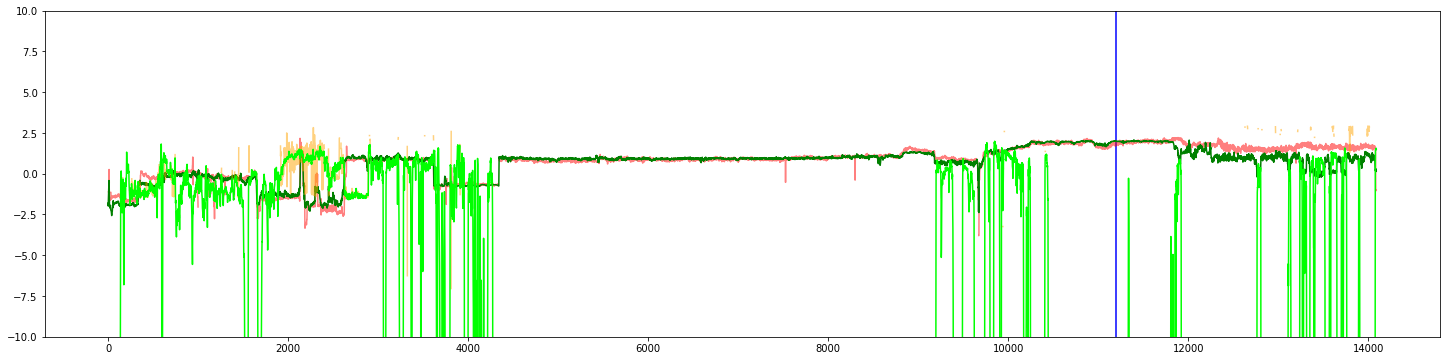

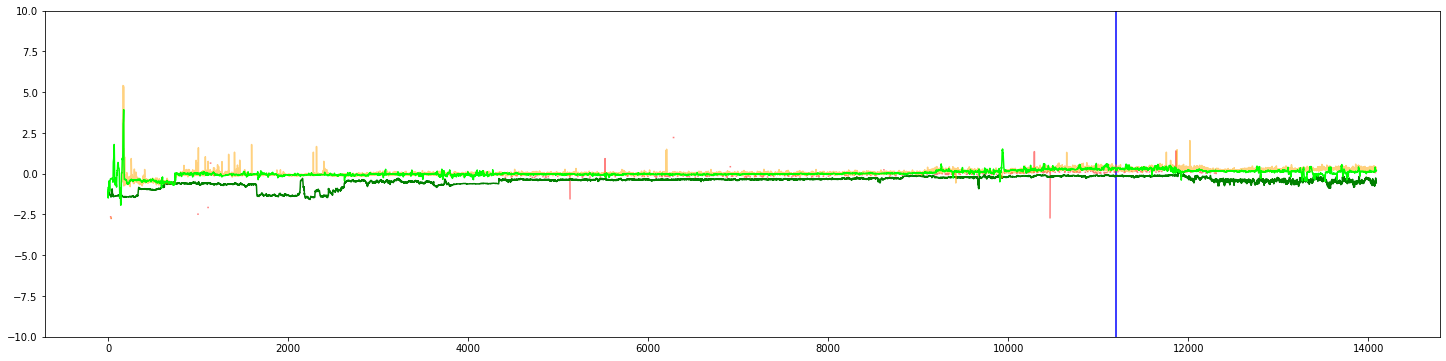

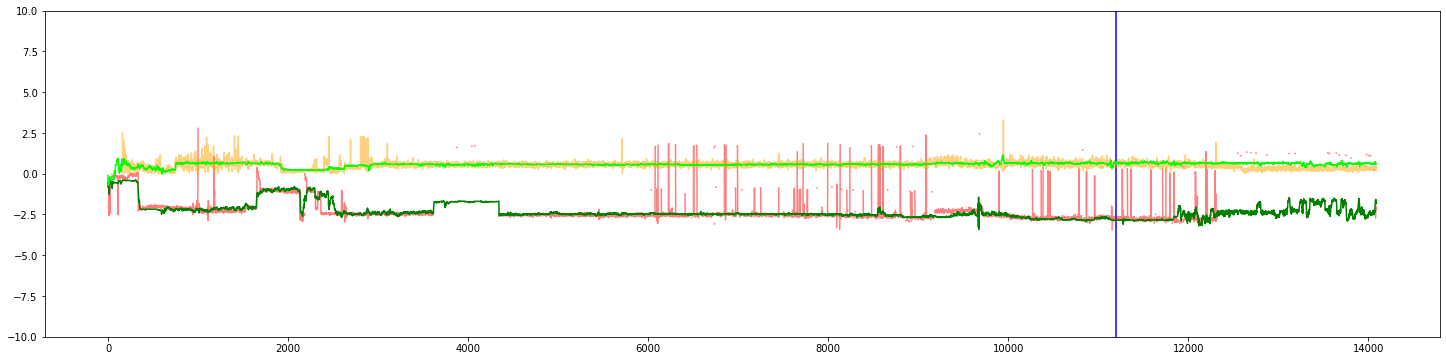

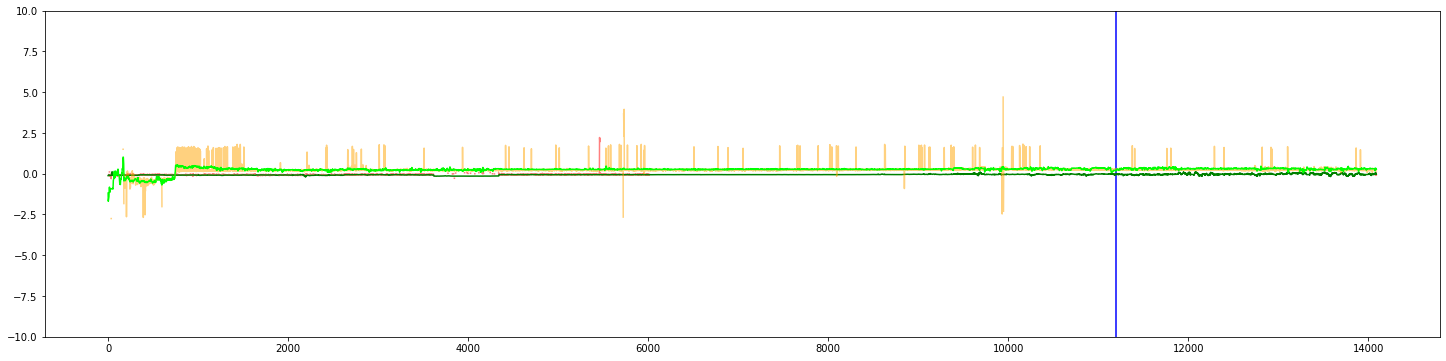

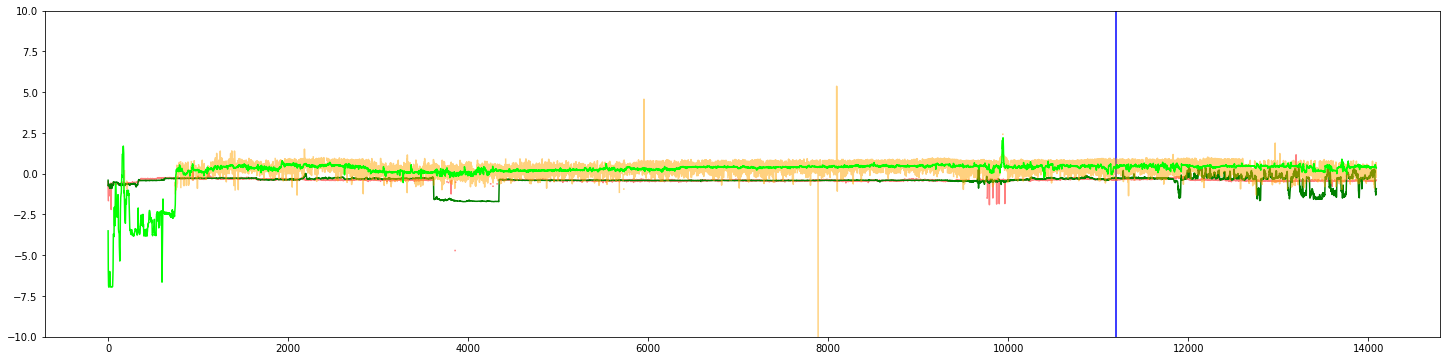

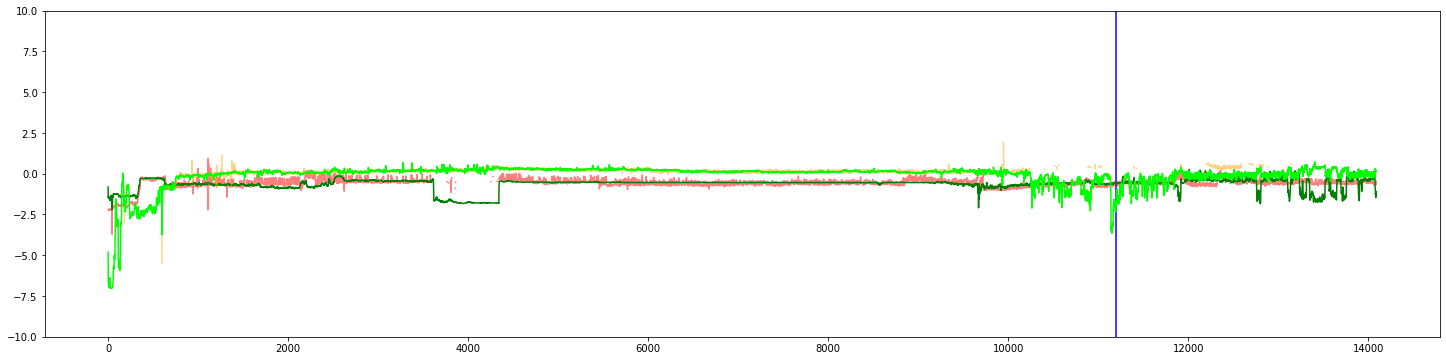

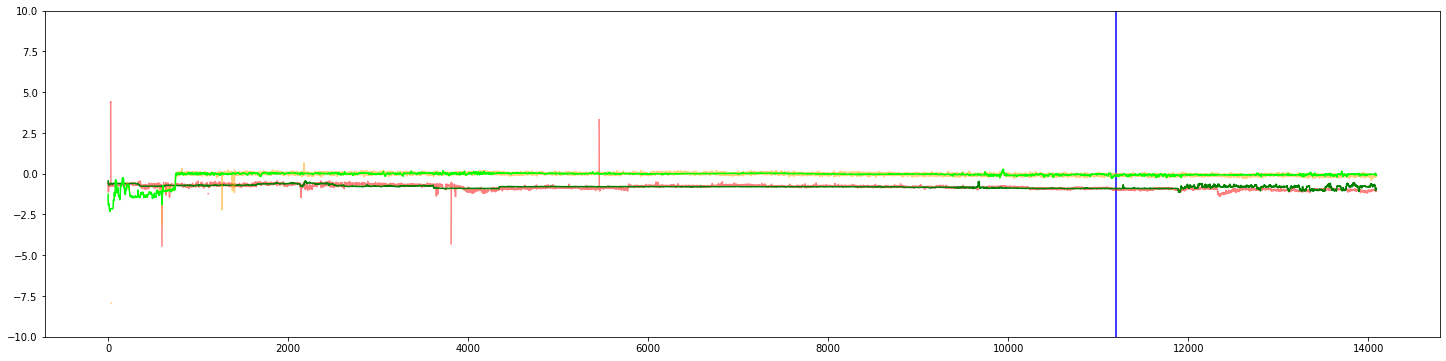

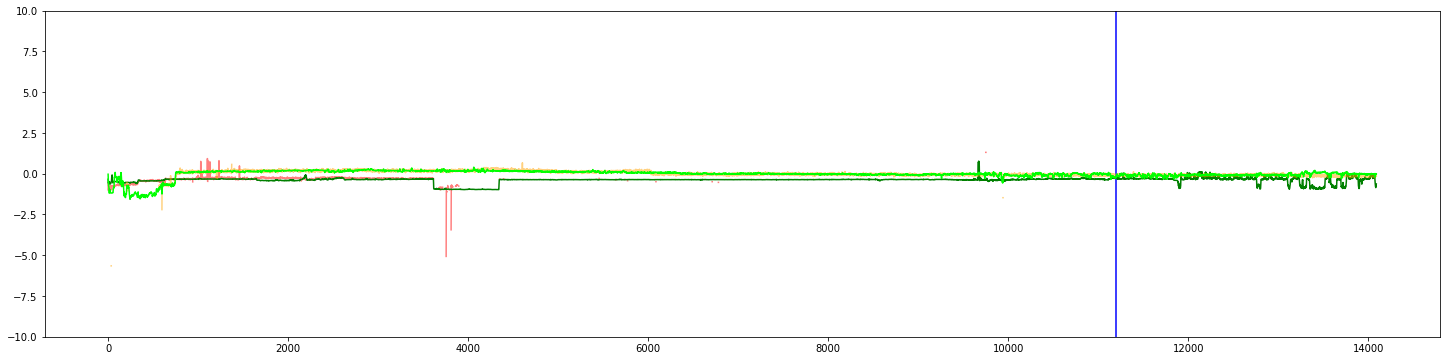

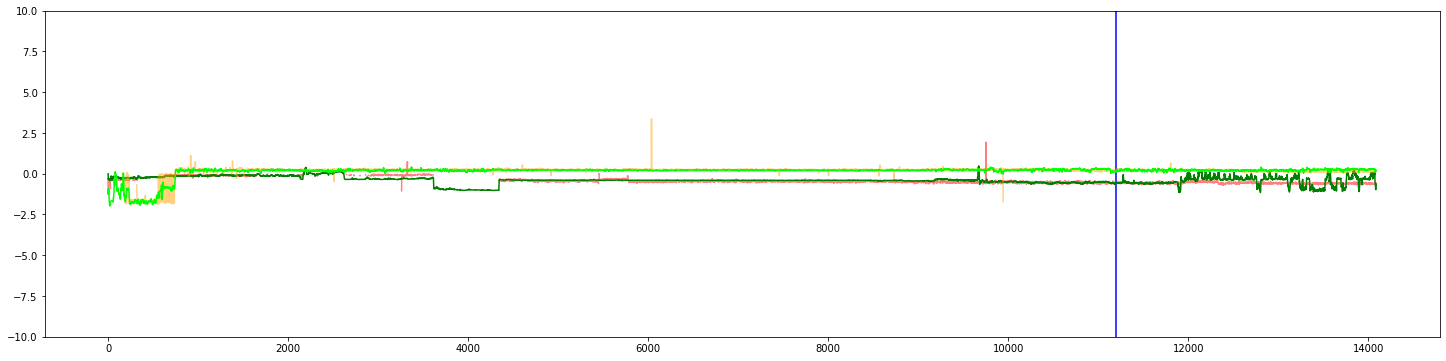

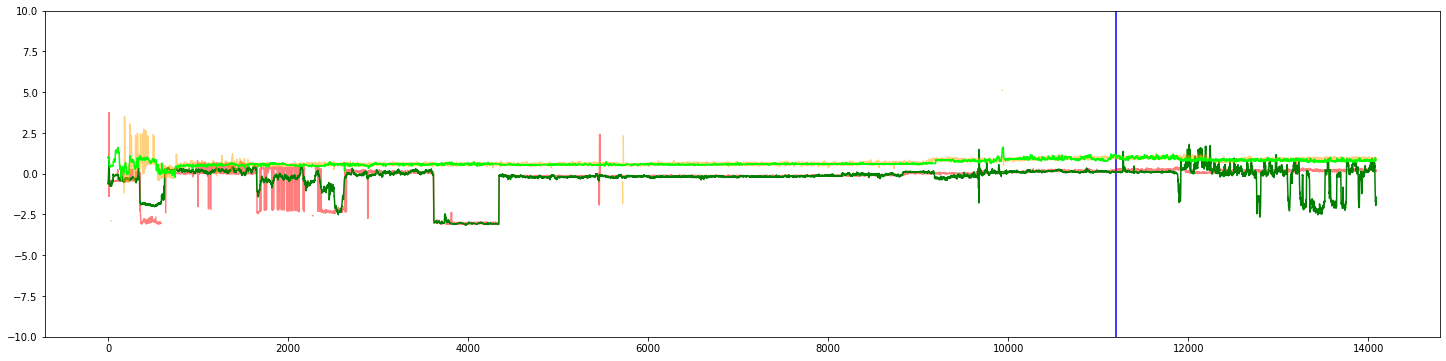

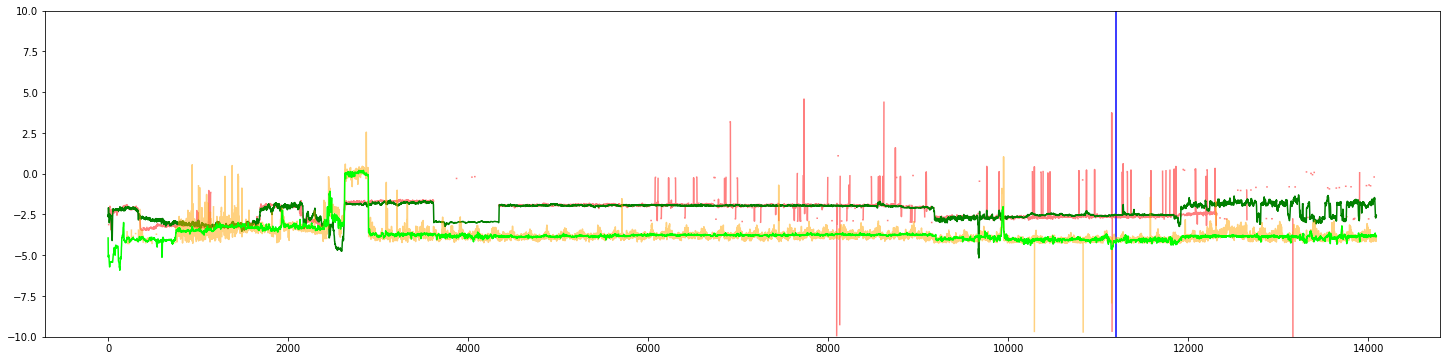

In [ ]:
pred_inputs = [
    np.expand_dims(t, 0) for t in
    (machine1_train_X, machine2_train_X, machine3_train_X, combiner_train_X, machine4_train_X, machine5_train_X)
]
p1_prediction = stage2_model.predict(pred_inputs)[0][0]
p2_prediction = stage2_model.predict(pred_inputs)[1][0]

for i in range(p1_prediction.shape[-1]):
    plt.plot(stage1_train_Y.iloc[PREDICTION_OFFSET:,i].values, 'r', alpha=0.5)    
    plt.plot(p1_prediction[:len(p1_prediction)-PREDICTION_OFFSET,i], "g")

    plt.plot(stage2_train_Y.iloc[PREDICTION_OFFSET:,i].values, color='orange', alpha=0.5)    
    plt.plot(p2_prediction[:len(p1_prediction)-PREDICTION_OFFSET,i], c="lime")

    plt.vlines([VALIDATION_MARK * STRIDE], -10, 10, colors='b')    
    plt.ylim(-10, 10)
    plt.show()  